
# Energy Consumption & Weather Patterns — Starter Notebook

**Goal:** Take raw energy and weather data → clean/merge → analyze relationships → communicate insights with clear visuals → Create an OLS → Train an OLS → Compare it.
**Deliverables:** Clean dataset, charts, and a short summary of findings.




## 0. Setup

In [95]:

# --- Environment & Imports ---
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Optional: scikit-learn for the mini-model
try:
    from sklearn.linear_model import LinearRegression
    SKLEARN_AVAILABLE = True
except Exception as e:
    SKLEARN_AVAILABLE = False

# Paths
BASE_DIR = Path().resolve()
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
FIG_DIR = BASE_DIR / "reports" / "figures"
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {BASE_DIR}")
print(f"Raw data folder: {DATA_RAW}")
print(f"Processed data folder: {DATA_PROCESSED}")
print(f"Figures folder: {FIG_DIR}")


Project root: C:\Users\diego\OneDrive\Documentos\PythonProjects\Energy Consumption & Weather Pattern Analysis
Raw data folder: C:\Users\diego\OneDrive\Documentos\PythonProjects\Energy Consumption & Weather Pattern Analysis\data\raw
Processed data folder: C:\Users\diego\OneDrive\Documentos\PythonProjects\Energy Consumption & Weather Pattern Analysis\data\processed
Figures folder: C:\Users\diego\OneDrive\Documentos\PythonProjects\Energy Consumption & Weather Pattern Analysis\reports\figures



# 1. Data Collection

Fill in either **CSV paths** (downloaded manually) or **API requests**.  
Keep raw files in `data/raw/`.

- Energy source idea: Kaggle datasets.
- Weather source ideas: Open-Meteo.


### 1.1 Energy dataset from internet (txt to csv)

In [96]:

energy_csv_path = DATA_RAW / "household_power_consumption.txt"   

energy = pd.read_csv(
    energy_csv_path, 
    sep=';', 
    decimal=',', 
    low_memory=False
)

energy.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Date                   object
 1   Time                   object
 2   Global_active_power    object
 3   Global_reactive_power  object
 4   Voltage                object
 5   Global_intensity       object
 6   Sub_metering_1         object
 7   Sub_metering_2         object
 8   Sub_metering_3         object
dtypes: object(9)
memory usage: 142.5+ MB


### 1.2 Weather dataset from an API

In [ ]:
#Weather dataset from france (API)

import requests

# Set API parameters
lat, lon = 48.8566, 2.3522  # Paris coords
start = "2006-12-01"
end = "2010-11-30"
timezone = "Europe/Paris"

# Variables you want (adjust if needed)
vars_list = [
    "temperature_2m",
    "relativehumidity_2m"
]

params = {
    "latitude": lat,
    "longitude": lon,
    "start_date": start,
    "end_date": end,
    "hourly": ",".join(vars_list),
    "timezone": timezone
}

url = "https://archive-api.open-meteo.com/v1/archive"

print("Requesting weather data from:", url)
resp = requests.get(url, params=params)
resp.raise_for_status()  # throw an error if bad status

weather_json = resp.json()

# Convert JSON to DataFrame
weather = pd.DataFrame(weather_json["hourly"]) #Free API that's why i can't request data per minute
# “hourly” includes timestamp column "time" and each variable

# Parse time column
weather["time"] = pd.to_datetime(weather["time"])
weather = weather.set_index("time")

# Save raw
DATA_RAW = Path("data/raw")
weather.to_csv(DATA_RAW / "paris_weather_2006_2010.csv", index=True)

weather.head()


Requesting weather data from: https://archive-api.open-meteo.com/v1/archive


,temperature_2m,relativehumidity_2m
time,,
2006-12-01 00:00:00,7.9,85
2006-12-01 01:00:00,7.6,86
2006-12-01 02:00:00,6.8,90
2006-12-01 03:00:00,6.3,92
2006-12-01 04:00:00,6.1,92



# 2. Cleaning & Merging

Standardize column names, parse datetimes, handle missing values, and align time granularity.  
Finally, merge energy and weather data on a shared time key (e.g., hourly timestamp).


### 2.1 Convert my columns into floats and datetime

In [98]:
#Convierto primero todas las columnas salvo 'Date' and 'Time' into floats
num_cols = energy.columns.difference(['Date', 'Time'])
energy[num_cols] = energy[num_cols].apply(pd.to_numeric, errors='coerce', downcast='float')

#Convierto despues 'Date' and 'Time' en una sola columna y en formato datetime
energy['Datetime'] = pd.to_datetime(
    energy['Date'] + ' ' + energy['Time'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce',
    cache=True
)

#Elimino las columnas antiguas relacionadas con el tiempo
energy.drop(columns=['Date', 'Time'], inplace=True)
energy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float32       
 1   Global_reactive_power  float32       
 2   Voltage                float32       
 3   Global_intensity       float32       
 4   Sub_metering_1         float32       
 5   Sub_metering_2         float32       
 6   Sub_metering_3         float32       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float32(7)
memory usage: 71.2 MB


### 2.2 Set the same DateTime to our dataframes

In [99]:
energy = energy.set_index('Datetime').sort_index();  

print("ENERGY BEFORE:",  energy.index.min(), "→", energy.index.max())
print("WEATHER BEFORE:", weather.index.min(), "→", weather.index.max())

start = max(energy.index.min(), weather.index.min())
end   = min(energy.index.max(), weather.index.max())

energy = energy.loc[start:end]
weather = weather.loc[start:end]

print("ENERGY AFTER:", energy.index.min(), "→", energy.index.max())
print("WEATHER AFTER:", weather.index.min(), "→", weather.index.max())



ENERGY BEFORE: 2006-12-16 17:24:00 → 2010-11-26 21:02:00
WEATHER BEFORE: 2006-12-01 00:00:00 → 2010-11-30 23:00:00
ENERGY AFTER: 2006-12-16 17:24:00 → 2010-11-26 21:02:00
WEATHER AFTER: 2006-12-16 18:00:00 → 2010-11-26 21:00:00


## 2.2 Handle missing values

### 2.2.1 Energy
First we need to now how our missing values are distributed

<Axes: title={'center': 'Missing Data Over Time'}, xlabel='Datetime'>

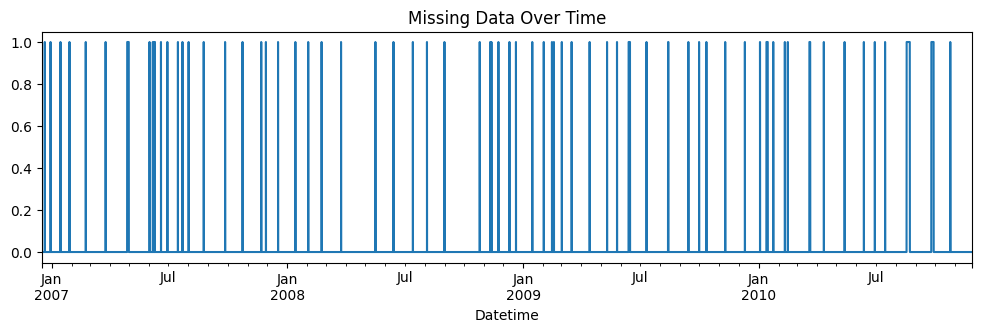

In [100]:

energy.isna().sum() #Check how many NaN values we have in our dataset (number)
energy.isna().mean(axis=1).plot(figsize=(12,3), title='Missing Data Over Time') #Check how these NaN values are distributed


### 2.2.1 Energy
When we already checked the distribution we fix it

<Axes: title={'center': 'After Interpolation'}, xlabel='Datetime'>

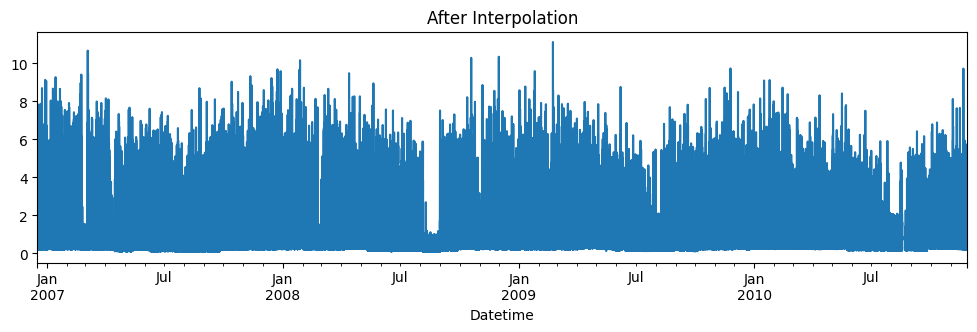

In [101]:
energy.interpolate(method='time', inplace=True) #We interpolate our Nan values
energy['Global_active_power'].plot(figsize=(12,3), title='After Interpolation') #We check our new values



### 2.2.1 Weather
All the data is correct,0 NaN values!

<Axes: title={'center': 'Missing Data Over Time'}, xlabel='Datetime'>

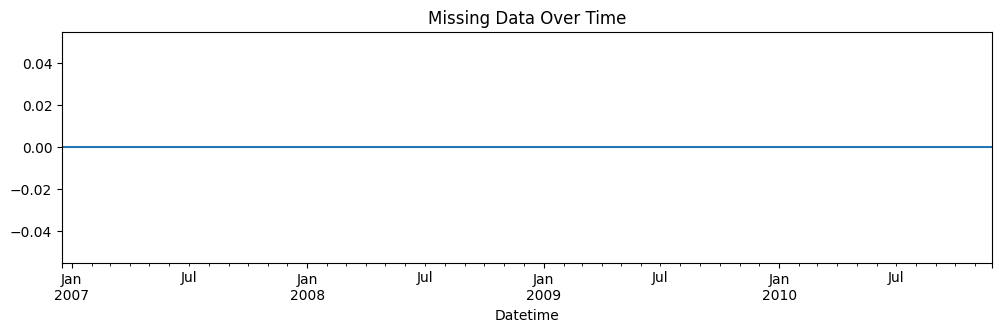

In [102]:
energy.isna().sum() #Check how many NaN values we have in our dataset (number)
energy.isna().mean(axis=1).plot(figsize=(12,3), title='Missing Data Over Time') #Check how these NaN values are distributed

## 2.3 Remove duplicates
### 2.3.1 Energy
With this code I can see that there are some columns that look exactly the same but this can be correct so I would prefer to not drop those rows.

In [103]:
energy.duplicated().sum() 
energy.index.duplicated().sum() #We use index.duplicated() to check if there is 2 rows with the same datetime

np.int64(0)

### 2.3.2 Weather
Same as energy dataframe

In [104]:
weather.duplicated().sum() 
weather.index.duplicated().sum()

np.int64(0)

## 2.4 Fix incosistent data
### 2.4.1 Energy
Puede haber muchas inconsistencias en my data como por ejemplo voltaje negativo,temperaturas sobrenaturales,sensor stuck,continuidad de mi datetime,etc.

Number of minutes with at least one sensor stuck: 3427
Number of minutes where ALL sensors froze: 341

Example of simultaneous freeze periods:
Datetime
2008-10-06 11:08:00   2008-10-06 11:08:00
2008-10-06 11:09:00   2008-10-06 11:09:00
2008-10-06 11:10:00   2008-10-06 11:10:00
2008-10-06 11:11:00   2008-10-06 11:11:00
2008-10-06 11:12:00   2008-10-06 11:12:00
2008-10-06 11:13:00   2008-10-06 11:13:00
2008-10-06 11:14:00   2008-10-06 11:14:00
2008-10-06 11:15:00   2008-10-06 11:15:00
2008-10-06 11:16:00   2008-10-06 11:16:00
2008-10-06 11:17:00   2008-10-06 11:17:00
Name: Datetime, dtype: datetime64[ns]
None


<Axes: title={'center': 'Number of Frozen Sensors Over Time'}, xlabel='Datetime'>

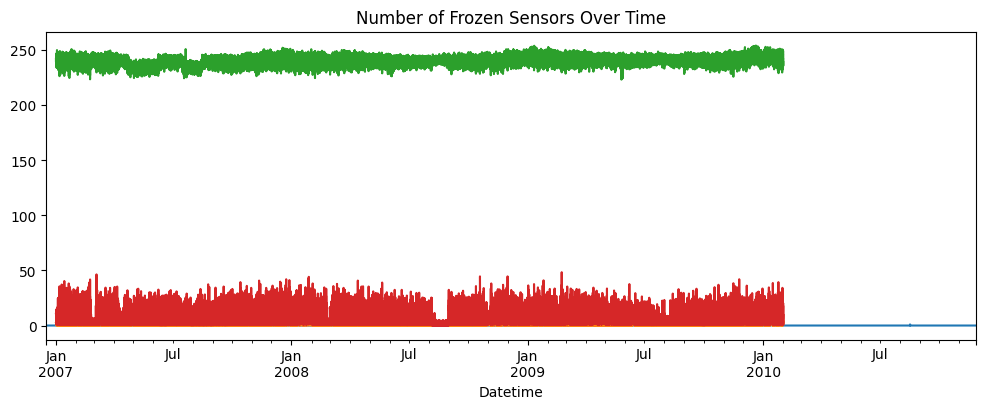

In [105]:
#============================================================================================================
#============================================================================================================

# 1. CHECK RANGES AND LOGIC
energy.describe()


#============================================================================================================
#============================================================================================================

# 2. CHECK NEGATIVE OR EXTREME VALUES
energy[(energy < 0).any(axis=1)] # 0 values

#============================================================================================================
#============================================================================================================

# 3. CHECK FOR CONSTANT READING (SENSOR STUCK)
# 👇 Choose columns to check
flat_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage']

# 1️⃣ Detect flat (constant) readings per column
stuck_df = pd.DataFrame({
    col: (energy[col].rolling(60).std() == 0)  # True if constant over 60 minutes
    for col in flat_columns
})

# 2️⃣ Count how many sensors are stuck at each time
stuck_df['stuck_count'] = stuck_df.sum(axis=1)

# 3️⃣ Find moments where ALL selected sensors are stuck
stuck_df['all_stuck'] = stuck_df['stuck_count'] == len(flat_columns)

# 4️⃣ Show summary
print("Number of minutes with at least one sensor stuck:", (stuck_df['stuck_count'] > 0).sum())
print("Number of minutes where ALL sensors froze:", stuck_df['all_stuck'].sum())

# 5️⃣ Show the first few datetimes where all sensors froze
stuck_times = stuck_df[stuck_df['all_stuck']].index
print("\nExample of simultaneous freeze periods:")
print(stuck_times.to_series().head(10))

# 6️⃣ Optional: visualize how many sensors were stuck over time
stuck_df['stuck_count'].plot(figsize=(12,4), title='Number of Frozen Sensors Over Time')

#CONCLUSION: HAY MUY POCOS VALORES REPETIDOS PARA TODO MI DATAFRAME ASIQUE LO DEJAMOS COMO ESTÁ

#============================================================================================================
#============================================================================================================

# 4. CHECK TIME CONTINUITY 
energy.index.to_series().diff().value_counts().head() #Salto entre datos (ej:1 min, 1 min, 1 min)

#CONCLUSION: PERFECTO

#============================================================================================================
#============================================================================================================

# 5. CHECK MISMATCHED FREQUENCIES
print(energy.index.freq) #Hay algun salto en el tiempo (10:02 --> 10:20)

#CONCLUSION: PERFECTO

#============================================================================================================
#============================================================================================================

# 6. PLOT UNUSUAL PERIODS
energy['Global_active_power']['2007-01':'2010-01'].plot()
energy['Voltage']['2007-01':'2010-01'].plot()
energy['Global_intensity']['2007-01':'2010-01'].plot()

#============================================================================================================
#============================================================================================================


### 2.4.2 Weather

Number of minutes with at least one sensor stuck: 0
Number of minutes where ALL sensors froze: 0

Example of simultaneous freeze periods:
Series([], Name: time, dtype: datetime64[ns])
None
DatetimeIndex(['2006-12-16 18:00:00', '2006-12-16 19:00:00',
               '2006-12-16 20:00:00', '2006-12-16 21:00:00',
               '2006-12-16 22:00:00', '2006-12-16 23:00:00',
               '2006-12-17 00:00:00', '2006-12-17 01:00:00',
               '2006-12-17 02:00:00', '2006-12-17 03:00:00',
               ...
               '2010-11-26 12:00:00', '2010-11-26 13:00:00',
               '2010-11-26 14:00:00', '2010-11-26 15:00:00',
               '2010-11-26 16:00:00', '2010-11-26 17:00:00',
               '2010-11-26 18:00:00', '2010-11-26 19:00:00',
               '2010-11-26 20:00:00', '2010-11-26 21:00:00'],
              dtype='datetime64[ns]', name='time', length=34588, freq=None)


<Axes: title={'center': 'Number of Frozen Sensors Over Time'}, xlabel='time'>

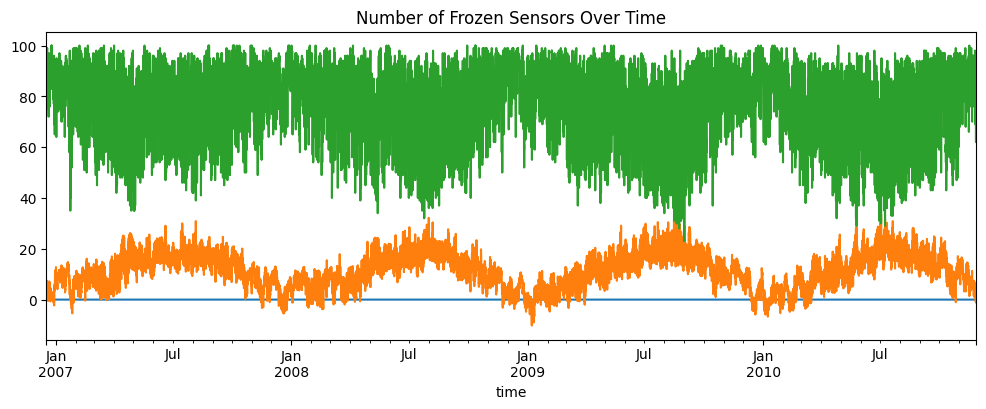

In [106]:
#============================================================================================================
#============================================================================================================

# 1. CHECK RANGES AND LOGIC
weather.describe()

#============================================================================================================
#============================================================================================================

# 2. CHECK NEGATIVE OR EXTREME VALUES
weather[(weather['temperature_2m'] < -40) | (weather['temperature_2m'] > 60)] #0 Values

#============================================================================================================
#============================================================================================================

# 3. CHECK FOR CONSTANT READING (SENSOR STUCK)
# 👇 Choose columns to check
flat_columns = ['temperature_2m', 'relativehumidity_2m']

# 1️⃣ Detect flat (constant) readings per column
stuck_df = pd.DataFrame({
    col: (weather[col].rolling(60).std() == 0)  # True if constant over 60 minutes
    for col in flat_columns
})

# 2️⃣ Count how many sensors are stuck at each time
stuck_df['stuck_count'] = stuck_df.sum(axis=1)

# 3️⃣ Find moments where ALL selected sensors are stuck
stuck_df['all_stuck'] = stuck_df['stuck_count'] == len(flat_columns)

# 4️⃣ Show summary
print("Number of minutes with at least one sensor stuck:", (stuck_df['stuck_count'] > 0).sum())
print("Number of minutes where ALL sensors froze:", stuck_df['all_stuck'].sum())

# 5️⃣ Show the first few datetimes where all sensors froze
stuck_times = stuck_df[stuck_df['all_stuck']].index
print("\nExample of simultaneous freeze periods:")
print(stuck_times.to_series().head(10))

# 6️⃣ Optional: visualize how many sensors were stuck over time
stuck_df['stuck_count'].plot(figsize=(12,4), title='Number of Frozen Sensors Over Time')

#CONCLUSION: 0 VALORES REPETIDOS!!

#============================================================================================================
#============================================================================================================

# 4. CHECK TIME CONTINUITY 
energy.index.to_series().diff().value_counts().head() #Salto entre datos (ej:1 min, 1 min, 1 min)

#CONCLUSION: PERFECTO

#============================================================================================================
#============================================================================================================

# 5. CHECK MISMATCHED FREQUENCIES
print(energy.index.freq) #Hay algun salto en el tiempo (10:02 --> 10:20)?

#CONCLUSION: PERFECTO

#============================================================================================================
#============================================================================================================

# 6. PLOT UNUSUAL PERIODS
print(weather.index)

weather['temperature_2m']['2006-12':'2010-11'].plot()
weather['relativehumidity_2m']['2006-12':'2010-11'].plot()

#============================================================================================================
#============================================================================================================


## 3. Exploratory Data Analysis (EDA)

Firts I need to do a "join" between my 2 tables 


In [107]:

# 1️⃣ Make sure both datasets are sorted by datetime
energy = energy.sort_index()
weather = weather.sort_index()

# 2️⃣ Reset indexes and rename datetime columns for clarity
energy = energy.reset_index().rename(columns={'Datetime': 'dt_energy'})
weather = weather.reset_index().rename(columns={'time': 'dt_weather'})

# 3️⃣ Convert datetime columns to proper datetime type (just to be safe)
energy['dt_energy'] = pd.to_datetime(energy['dt_energy'])
weather['dt_weather'] = pd.to_datetime(weather['dt_weather'])

# 4️⃣ Merge with the last known weather (per hour) for each energy minute
merged = pd.merge_asof(
    energy.sort_values('dt_energy'),
    weather.sort_values('dt_weather'),
    left_on='dt_energy',
    right_on='dt_weather',
    direction='backward',                  # use last known weather data
    tolerance=pd.Timedelta('1H')           # only if within 1 hour
)

# 5️⃣ Optional — set datetime as index again
merged = merged.set_index('dt_energy')

# 6️⃣ Display summary
print(f"Merged dataset shape: {merged.shape}")
print(f"Time range: {merged.index.min()}  →  {merged.index.max()}")
print(f"Columns: {list(merged.columns)}")

# 7️⃣ (Optional) Quick check for missing weather values
missing_weather = merged[['temperature_2m', 'relativehumidity_2m']].isna().sum()
print("\nMissing weather values after merge:")
print(missing_weather)





C:\Users\diego\AppData\Local\Temp\ipykernel_1428\2488964004.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta('1H')           # only if within 1 hour


Merged dataset shape: (2075259, 10)
Time range: 2006-12-16 17:24:00  →  2010-11-26 21:02:00
Columns: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'dt_weather', 'temperature_2m', 'relativehumidity_2m']

Missing weather values after merge:
temperature_2m         36
relativehumidity_2m    36
dtype: int64


In [108]:

merged.drop(columns=['dt_weather'], inplace=True)
merged.index.name = 'DateTime'
merged.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temperature_2m,relativehumidity_2m
DateTime,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,NaN,NaN
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,NaN,NaN
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,NaN,NaN
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,NaN,NaN
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,NaN,NaN



## 3.1 Distributions
To understand who each variable behaves (ragnes,skewness,outliers...)


In [109]:
numeric_cols = merged.columns
for col in numeric_cols:
    print(f'The skew for {col} is: {merged[col].skew():.3f}')


The skew for Global_active_power is: 1.792
The skew for Global_reactive_power is: 1.263
The skew for Voltage is: -0.325
The skew for Global_intensity is: 1.855
The skew for Sub_metering_1 is: 5.984
The skew for Sub_metering_2 is: 7.136
The skew for Sub_metering_3 is: 0.730
The skew for temperature_2m is: -0.025
The skew for relativehumidity_2m is: -0.661


C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


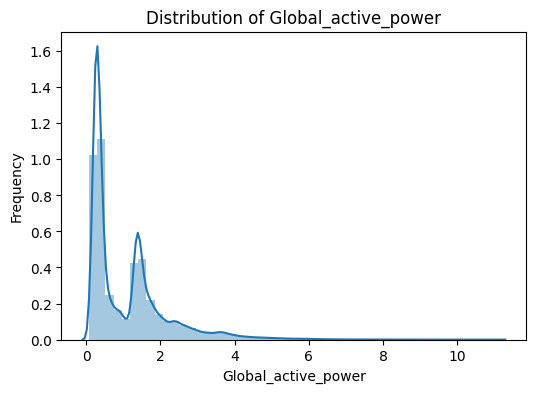

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


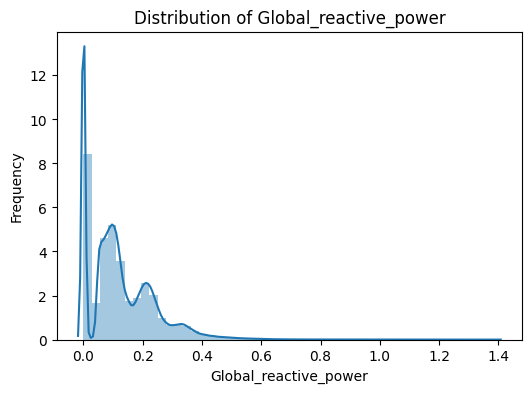

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


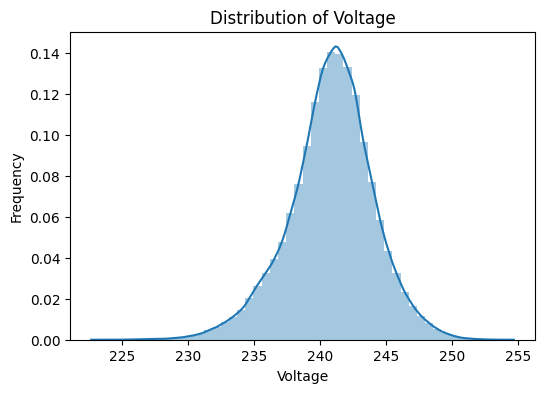

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


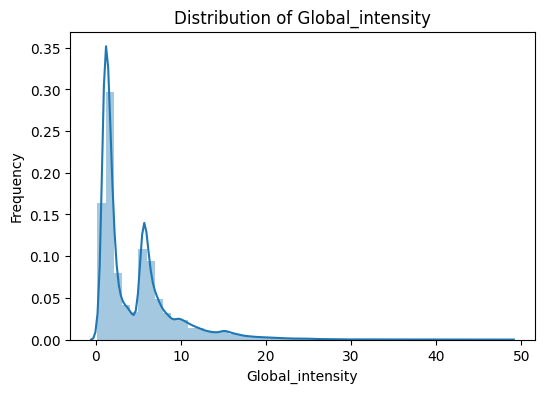

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


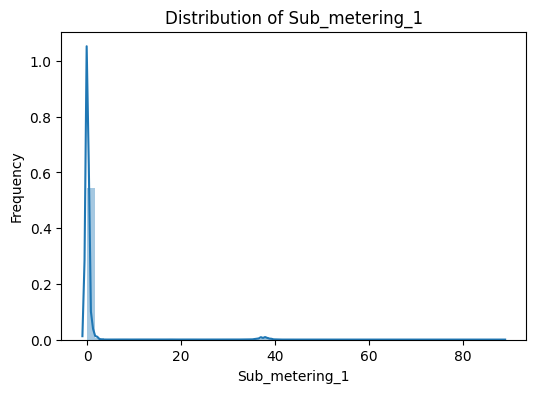

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


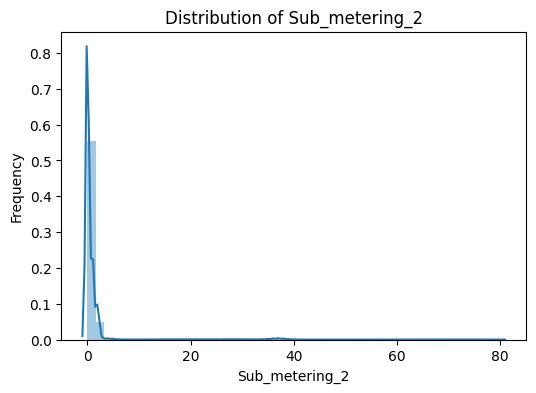

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


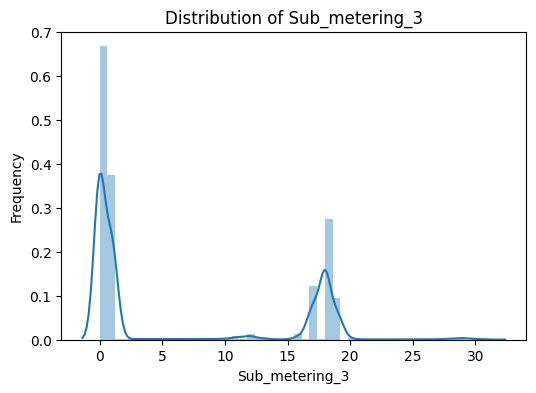

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


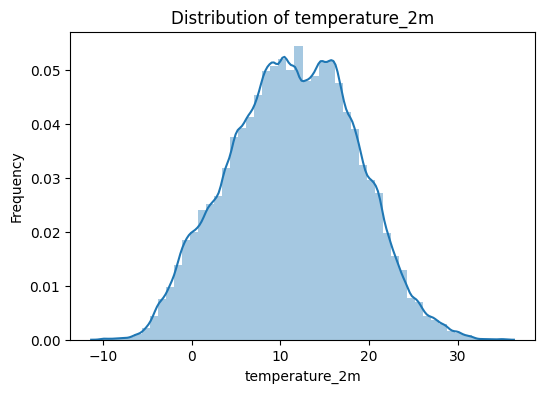

C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3671902331.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged[col], kde=True, bins=50)


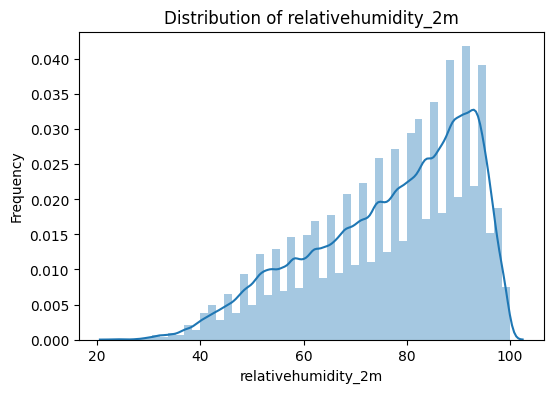

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = merged.columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.distplot(merged[col], kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


## 3.2 Correlations
Heatmap to measure how strongly 2 vairables move together.
- +1.0 Value == Perfect positive relationship
- 0 == No relationship
- -1.o Value == Perfect negative relationship

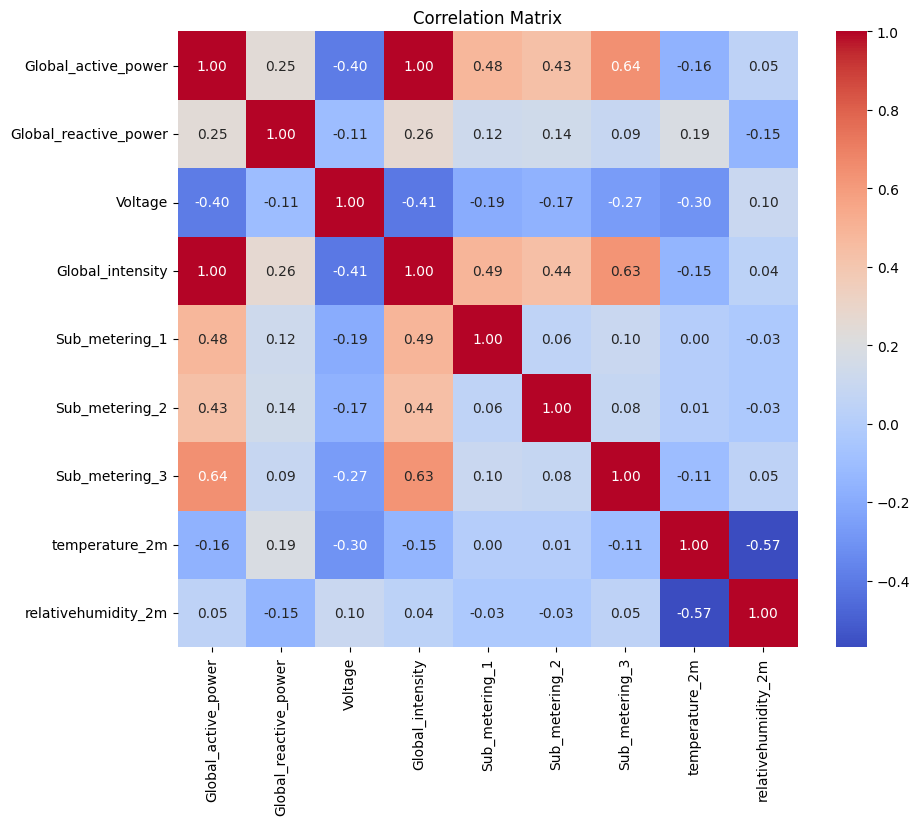

In [111]:
plt.figure(figsize=(10,8))
sns.heatmap(merged.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

What we can see in our heatmap is that the relationship between temperature and global active power is very weak (-0.16) and that's not a normal patern. So I'm going to apply some tricks to try to improve this correlation.

### 3.2.1 Reduce noise
Minute-level noise obscures the temperature effect, so I decided to aggregate the data to hourly and daily intervals.

In [112]:

merged.index = pd.to_datetime(merged.index)

# Hourly & daily averages
merged_h = merged.resample('H').mean(numeric_only=True)
merged_d = merged.resample('D').mean(numeric_only=True)

# merged_h.head(), merged_d.head()



C:\Users\diego\AppData\Local\Temp\ipykernel_1428\3993942617.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged_h = merged.resample('H').mean(numeric_only=True)


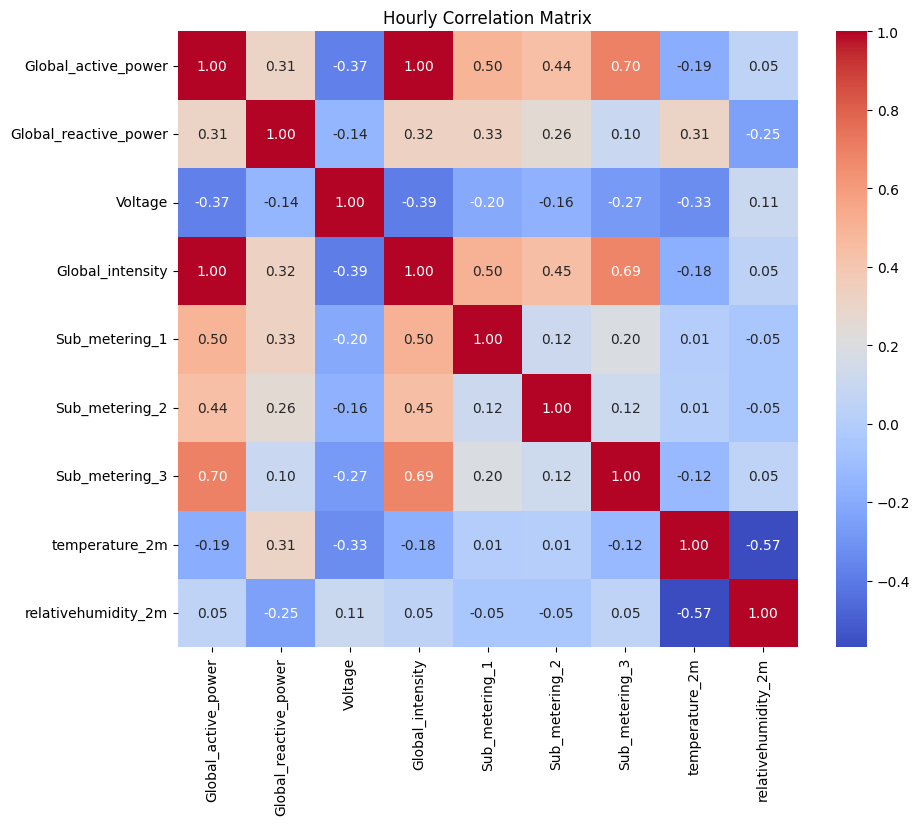

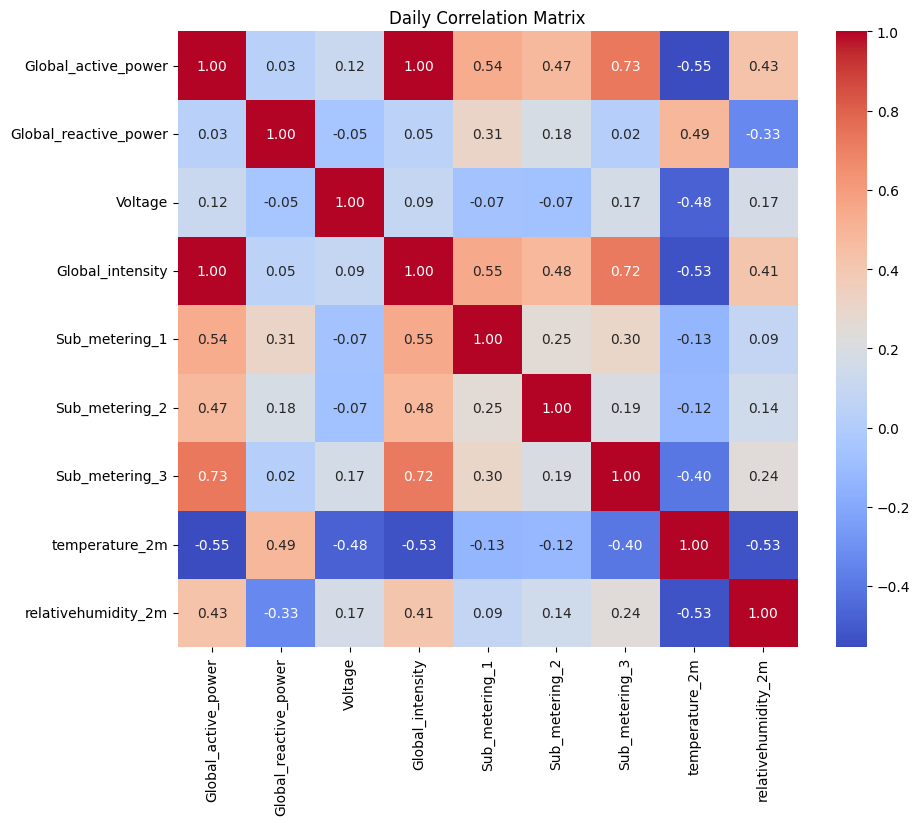

In [113]:
#Hourly correlation
plt.figure(figsize=(10,8))
sns.heatmap(merged_h.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Hourly Correlation Matrix")
plt.show()

#Daily correlation
plt.figure(figsize=(10,8))
sns.heatmap(merged_d.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Daily Correlation Matrix")
plt.show()

As we can see from the daily correlation matrix, the relationship between global active power and temperature is stronger (–0.55). This happens because we reduced various sources of noise, such as short-term appliance usage, random voltage fluctuations, and brief occupancy changes that affect hourly readings but not daily averages.

## 3.3 Identify, select and visualize
 Let's select the strongest correlations and visualize how they work

In [114]:
corr = merged_d.corr(numeric_only=True)

# Unstack correlations and reset to DataFrame
corr_pairs = corr.unstack().sort_values(ascending=False).reset_index()
corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlation']

# Remove duplicates (A,B) == (B,A)
corr_pairs = corr_pairs[corr_pairs['Variable_1'] < corr_pairs['Variable_2']]

# Show top and bottom correlations
print("🔹 Top 10 strongest correlations:\n")
print(corr_pairs.head(10))
print("\n🔹 Top 10 strongest negative correlations:\n")
print(corr_pairs.tail(10))


🔹 Top 10 strongest correlations:

               Variable_1           Variable_2  Correlation
10    Global_active_power     Global_intensity     0.999177
11    Global_active_power       Sub_metering_3     0.731414
13       Global_intensity       Sub_metering_3     0.723041
16       Global_intensity       Sub_metering_1     0.547910
17    Global_active_power       Sub_metering_1     0.535734
20  Global_reactive_power       temperature_2m     0.486374
22       Global_intensity       Sub_metering_2     0.481627
23    Global_active_power       Sub_metering_2     0.472477
26    Global_active_power  relativehumidity_2m     0.425700
28       Global_intensity  relativehumidity_2m     0.414466

🔹 Top 10 strongest negative correlations:

               Variable_1           Variable_2  Correlation
62         Sub_metering_1              Voltage    -0.066089
63         Sub_metering_2              Voltage    -0.070962
65         Sub_metering_2       temperature_2m    -0.122665
68         Sub_meterin

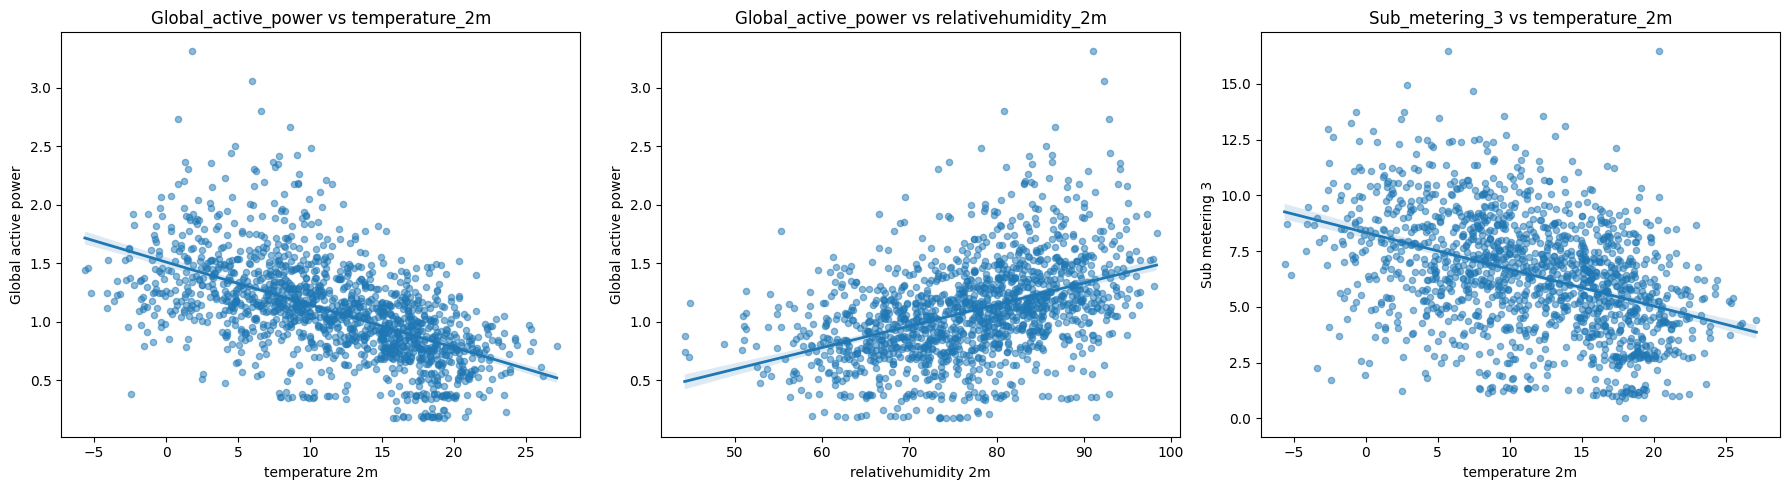

=== Linearity check (daily data) ===
Global_active_power ~ temperature_2m:  Pearson r = -0.555 (p=3.27e-117),  R² = 0.308,  slope = -0.0365,  intercept = 1.5090
Global_active_power ~ relativehumidity_2m:  Pearson r = 0.426 (p=1.49e-64),  R² = 0.181,  slope = 0.0184,  intercept = -0.3233
Sub_metering_3 ~ temperature_2m:  Pearson r = -0.402 (p=3.61e-57),  R² = 0.162,  slope = -0.1648,  intercept = 8.3328

=== OLS: Global_active_power ~ temperature_2m + relativehumidity_2m ===
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.8243      0.096      8.570      0.000       0.636       1.013
temperature_2m         -0.0301      0.002    -18.044      0.000      -0.033      -0.027
relativehumidity_2m     0.0079      0.001      7.256      0.000       0.006       0.010

=== OLS with quadratic temperature term ===
                          coef    st

In [115]:
# === Visual + numeric validation of strongest weather–energy pairs ===
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import pearsonr

pairs = [
    ('temperature_2m', 'Global_active_power'),   # core climate effect
    ('relativehumidity_2m', 'Global_active_power'),  # secondary weather factor
    ('temperature_2m', 'Sub_metering_3')         # circuit-level response
]

# Ensure we have the daily frame
assert 'merged_d' in globals(), "merged_d not found. Create daily resampled DataFrame first."

# --- 1) Scatter + linear trend (and optional quadratic fit) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (xcol, ycol) in zip(axes, pairs):
    data = merged_d[[xcol, ycol]].dropna()
    sns.regplot(data=data, x=xcol, y=ycol, ax=ax, line_kws={'linewidth':2}, scatter_kws={'alpha':0.5, 's':20})
    ax.set_title(f'{ycol} vs {xcol}')
    ax.set_xlabel(xcol.replace('_',' '))
    ax.set_ylabel(ycol.replace('_',' '))

plt.tight_layout()
plt.show()

# --- 2) Numeric linearity check: Pearson r and R² from linear regression ---
print("=== Linearity check (daily data) ===")
for xcol, ycol in pairs:
    data = merged_d[[xcol, ycol]].dropna()
    X = data[[xcol]].values
    y = data[ycol].values
    # Pearson correlation
    r, p = pearsonr(X.ravel(), y)
    # Simple linear regression
    lr = LinearRegression().fit(X, y)
    y_pred = lr.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"{ycol} ~ {xcol}:  Pearson r = {r:.3f} (p={p:.2e}),  R² = {r2:.3f},  slope = {lr.coef_[0]:.4f},  intercept = {lr.intercept_:.4f}")

# --- 3) OLS with temperature + humidity together (quantify joint effect) ---
X = merged_d[['temperature_2m','relativehumidity_2m']].dropna()
Y = merged_d.loc[X.index, 'Global_active_power']

X_ols = sm.add_constant(X)
ols = sm.OLS(Y, X_ols).fit()
print("\n=== OLS: Global_active_power ~ temperature_2m + relativehumidity_2m ===")
print(ols.summary().tables[1])  # compact coeff table

# --- 4) Optional: show curvature with quadratic term for temperature ---
Xq = X.copy()
Xq['temp2'] = Xq['temperature_2m']**2
ols_q = sm.OLS(Y, sm.add_constant(Xq)).fit()
print("\n=== OLS with quadratic temperature term ===")
print(ols_q.summary().tables[1])


**Pearson r** -> How strong is the correlation between 2 variables (-1,1)

**R²** -> It tells you how much of the variation in one variable can be explained by the other (It's literally r²). For example 0.308 -> 30.8% of the variation can be explained by the other variable

**Slope** -> It's the rate of change, how much your dependant variable changes when the independant variable increases by 1 unit. Ex: For temperature -> Every +1ºC is associated with -0.0365 kW.


### Right now, I would like to plot our OLS model to visualize it

                             OLS Regression Results                            
Dep. Variable:     Global_active_power   R-squared:                       0.332
Model:                             OLS   Adj. R-squared:                  0.331
Method:                  Least Squares   F-statistic:                     358.1
Date:                 Tue, 21 Oct 2025   Prob (F-statistic):          6.14e-127
Time:                         16:25:18   Log-Likelihood:                -507.26
No. Observations:                 1442   AIC:                             1021.
Df Residuals:                     1439   BIC:                             1036.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   

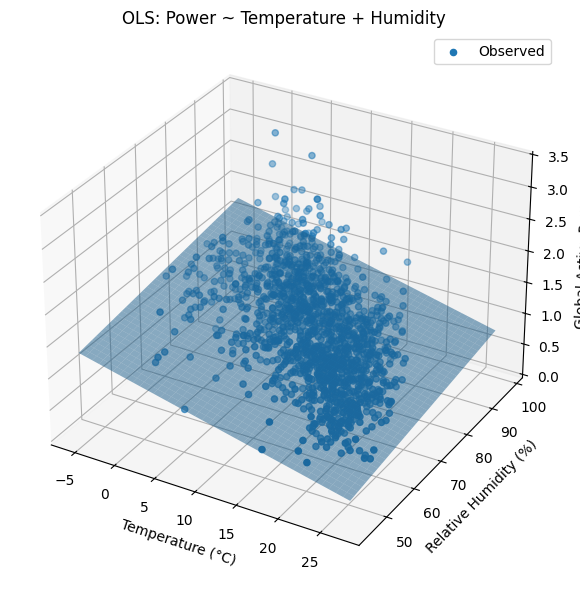

In [ ]:
# 3D plot of OLS plane for: Global_active_power ~ temperature_2m + relativehumidity_2m

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)


# --- 1) Prepare your data (assumes df has these columns) ---
# Replace df with your dataframe variable if different
X = merged_d[['temperature_2m', 'relativehumidity_2m']].copy()
y = merged_d['Global_active_power'].copy()

# Add constant for intercept
X_const = sm.add_constant(X)

# --- 2) Fit OLS (or skip if you already have a fitted model) ---
model = sm.OLS(y, X_const).fit()
print(model.summary())

# --- 3) Make a prediction grid over the range of your data ---
t_min, t_max = X['temperature_2m'].min(), X['temperature_2m'].max()
h_min, h_max = X['relativehumidity_2m'].min(), X['relativehumidity_2m'].max()

t_grid, h_grid = np.meshgrid(
    np.linspace(t_min, t_max, 40),
    np.linspace(h_min, h_max, 40)
)
grid = pd.DataFrame({
    'const': 1.0,
    'temperature_2m': t_grid.ravel(),
    'relativehumidity_2m': h_grid.ravel()
})
z_pred = model.predict(grid).values.reshape(t_grid.shape)

# --- 4) Plot: scatter (actual) + surface (fitted plane) ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter of actual data
ax.scatter(
    X['temperature_2m'],
    X['relativehumidity_2m'],
    y,
    label='Observed'
)

# Regression plane
ax.plot_surface(t_grid, h_grid, z_pred, alpha=0.5, linewidth=0, antialiased=True)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Relative Humidity (%)')
ax.set_zlabel('Global Active Power')
ax.set_title('OLS: Power ~ Temperature + Humidity')
ax.legend()
plt.tight_layout()
plt.show()


As we can see our R-squared = 0.332 so basically this means there's still a lot of variability unexplained (about 67% of changes in power depends on other factors). Temperature and humidity definetly matter,but power usage depends also on: Time of day or season, solar radiation, day of the week, wind speed and more. 




## 4. Simple Predictive Model (Randomly selected)
So now I would like to train our model with different % of train/test in order to see whether I can build a model that accurately predicts the variation in power consumption based on temperature and humidity (not to predict the future, only to see if I can create a good model)



   Train %  Train R²  Test R²  Train RMSE  Test RMSE
0       50     0.306    0.356       0.354      0.335
1       60     0.316    0.357       0.352      0.332
2       70     0.323    0.350       0.343      0.347
3       80     0.326    0.348       0.341      0.357
4       90     0.334    0.311       0.340      0.376


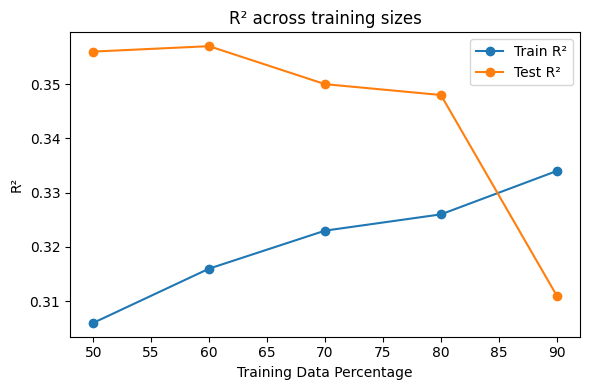

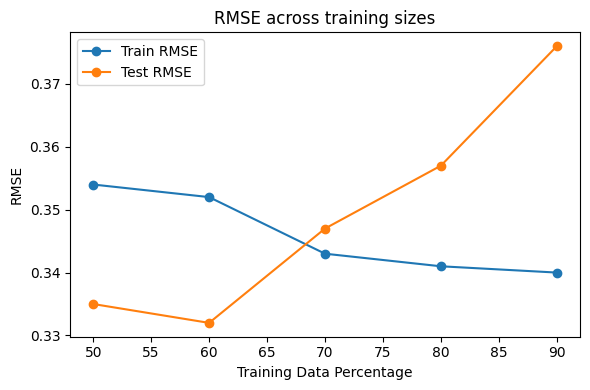

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# --- 0) Features & target ---
X = merged_d[['temperature_2m', 'relativehumidity_2m']].copy()
y = merged_d['Global_active_power'].copy()
X_const = sm.add_constant(X)

# --- 1) Train sizes to test ---
train_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

rows = []
for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X_const, y, train_size=size, random_state=42
    )

    # Fit OLS on the training set
    model = sm.OLS(y_train, X_train).fit()

    # Predict on train and test
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Metrics
    r2_train = model.rsquared                              # training R² (statsmodels)
    r2_test  = r2_score(y_test, y_pred_test)               # test R²  (sklearn)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test,  y_pred_test))

    rows.append({
        'Train %': int(size * 100),
        'Train R²': round(r2_train, 3),
        'Test R²':  round(r2_test,  3),
        'Train RMSE': round(rmse_train, 3),
        'Test RMSE':  round(rmse_test,  3),
    })

results_df = pd.DataFrame(rows).sort_values('Train %').reset_index(drop=True)
print(results_df)

# --- 2) Plots ---
# R² vs train size
plt.figure(figsize=(6,4))
plt.plot(results_df['Train %'], results_df['Train R²'], marker='o', label='Train R²')
plt.plot(results_df['Train %'], results_df['Test R²'],  marker='o', label='Test R²')
plt.xlabel('Training Data Percentage')
plt.ylabel('R²')
plt.title('R² across training sizes')
plt.legend()
plt.tight_layout()
plt.show()

# RMSE vs train size
plt.figure(figsize=(6,4))
plt.plot(results_df['Train %'], results_df['Train RMSE'], marker='o', label='Train RMSE')
plt.plot(results_df['Train %'], results_df['Test RMSE'],  marker='o', label='Test RMSE')
plt.xlabel('Training Data Percentage')
plt.ylabel('RMSE')
plt.title('RMSE across training sizes')
plt.legend()
plt.tight_layout()
plt.show()


The best-performing model is around 60–70% training data, because:

1) It has the highest and most stable test R²

2) The lowest RMSE (error)

3) Avoids overfitting or instability at high training percentages

### 3D: compare OLS (all data) vs OLS (70% train)
To compare visually the difference between the two models

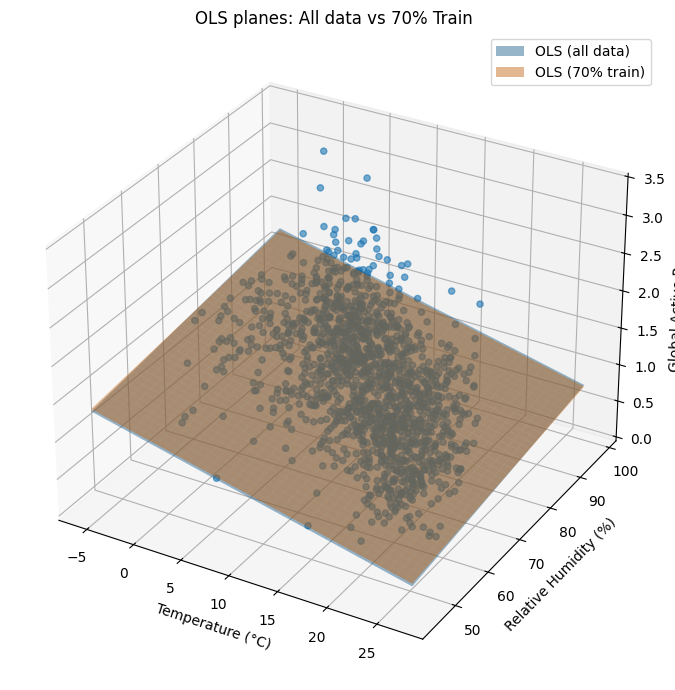

R² (all data fit): 0.332
R² (70% train):    0.323


In [118]:
from matplotlib.lines import Line2D

# ---- 1) Prepare data (rename df if your variable is different)
X = merged_d[['temperature_2m', 'relativehumidity_2m']].copy()
y = merged_d['Global_active_power'].copy()
Xc = sm.add_constant(X)

# ---- 2) Fit OLS on ALL data
model_all = sm.OLS(y, Xc).fit()

# ---- 3) Fit OLS on 70% TRAIN split
X_train, X_test, y_train, y_test = train_test_split(Xc, y, train_size=0.7, random_state=42)
model_70 = sm.OLS(y_train, X_train).fit()

# ---- 4) Build a grid over the full data ranges
t_min, t_max = X['temperature_2m'].min(), X['temperature_2m'].max()
h_min, h_max = X['relativehumidity_2m'].min(), X['relativehumidity_2m'].max()
t_grid, h_grid = np.meshgrid(
    np.linspace(t_min, t_max, 40),
    np.linspace(h_min, h_max, 40)
)
grid = pd.DataFrame({
    'const': 1.0,
    'temperature_2m': t_grid.ravel(),
    'relativehumidity_2m': h_grid.ravel()
})

# Predictions for both planes
z_all = model_all.predict(grid).values.reshape(t_grid.shape)
z_70  = model_70.predict(grid).values.reshape(t_grid.shape)

# ---- 5) Plot: scatter(all points) + both planes
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter of ALL data
ax.scatter(X['temperature_2m'], X['relativehumidity_2m'], y, alpha=0.6)

# Two regression planes (different default colors; semi-transparent)
surf_all = ax.plot_surface(t_grid, h_grid, z_all, alpha=0.45, linewidth=0)
surf_70  = ax.plot_surface(t_grid, h_grid, z_70,  alpha=0.45, linewidth=0)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Relative Humidity (%)')
ax.set_zlabel('Global Active Power')
ax.set_title('OLS planes: All data vs 70% Train')

# Legend proxies (to label the two surfaces)
# ---- Legend and labels (simpler and version-safe)
ax.legend(
    [surf_all, surf_70],
    ['OLS (all data)', 'OLS (70% train)'],
    loc='best'
)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Relative Humidity (%)')
ax.set_zlabel('Global Active Power')
ax.set_title('OLS planes: All data vs 70% Train')

plt.tight_layout()
plt.show()

# Optional R² comparison
print(f"R² (all data fit): {model_all.rsquared:.3f}")
print(f"R² (70% train):    {model_70.rsquared:.3f}")

